In [1]:
import os
import json
import time
from collections import OrderedDict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import itertools as it
from reaction_network.fjss import FJS2
import plotly.express as px
from reaction_network.utils import *

In [2]:
# automatically reimport modules when they change
%load_ext autoreload

## A minimal example of how to use the FJS2 class

In [3]:
# set up the input data

# minimum lag time
para_lmin = np.full((5, 5), fill_value=-np.inf)
para_lmin[0, 1] = 2
para_lmin[2, 3] = 2
para_lmin[3, 4] = 2
# para_lmin

# maximum lag time
para_lmax = np.full((5, 5), fill_value=np.inf)
para_lmax[0, 1] = 5
para_lmax[2, 3] = 5
para_lmax[3, 4] = 5

# para_p
para_p = np.full((5, 3), fill_value=np.inf)
for i in [idx - 1 for idx in [1, 3, 5]]:
    for m in [idx - 1 for idx in [1, 3]]:
        para_p[i, m] = 5

for i in [idx - 1 for idx in [2, 4]]:
    for m in [1]:
        para_p[i, m] = 10

para_h = np.full((5, 3), fill_value=2)

# para_w
para_w = np.full((5, 3), fill_value=1)

# para_a, a_mij
para_a = np.full((3, 5, 5), fill_value=-np.inf)
para_a[0, 0, 4] = 5
para_a[0, 4, 0] = 5

# para_mach_capacity
para_mach_capacity = np.array([2, 2, 2])

# para_delta
para_delta = np.array([1, 1, 1])

In [4]:
num_operations = 5
num_machines = 3

operations = {str(i): str(i) for i in range(num_operations)}
operations = OrderedDict(sorted(operations.items(), key=lambda x: int(x[0])))

machines = {str(i): str(i) for i in range(num_machines)}
machines = OrderedDict(sorted(machines.items(), key=lambda x: int(x[0])))

print(f"operations: {operations}")
print(f"machines: {machines}")

operations: OrderedDict([('0', '0'), ('1', '1'), ('2', '2'), ('3', '3'), ('4', '4')])
machines: OrderedDict([('0', '0'), ('1', '1'), ('2', '2')])


In [5]:
# the job information
operation_job_dict = {
    "0": "1",
    "1": "1",
    "2": "2",
    "3": "2",
    "4": "2",
}

job_operation_dict = {
    "1": ["0", "1"],
    "2": ["2", "3", "4"],
}

In [6]:
# this function ensure the shape of para_a is correct
para_a = check_fix_shape_of_para_a(para_p, para_a, intended_for="milp")

# para_a[4, 0, 0]

In [7]:
# solve the case study in the original with FJS2
infinity = 1.0e7
verbose = True
new_row = OrderedDict()

new_row["n_opt"] = num_operations
new_row["n_mach"] = num_machines

print("solve the MILP problem with FJSS4_v2")
# check the running time
start_time = time.time()
fjss2 = FJS2(
    operations=operations,
    machines=machines,
    para_p=para_p,
    para_a=para_a,
    para_w=para_w,
    para_h=para_h,
    para_delta=para_delta,
    para_mach_capacity=para_mach_capacity,
    para_lmin=para_lmin,
    para_lmax=para_lmax,
    model_string=None,
    inf_milp=infinity,
    workshifts=None,
    # workshifts=[(900, 120)] * 5,
    # workshifts=[(100, 20)] * 1,
    operations_subset_indices=None,
    num_workers=None,
    verbose=verbose,
    big_m=None,
)
fjss2.build_model_gurobi()
fjss4_output = fjss2.solve_gurobi()
end_time = time.time()
running_time_seconds = end_time - start_time
new_row["running_time_seconds"] = running_time_seconds

solve the MILP problem with FJSS4_v2
the inferred big_m value with Runzhong version is 54.0
Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-27


Gurobi Optimizer version 11.0.0 build v11.0.0rc2 (linux64 - "Ubuntu 20.04.4 LTS")

CPU model: AMD Ryzen Threadripper PRO 3995WX 64-Cores, instruction set [SSE2|AVX|AVX2]
Thread count: 64 physical cores, 128 logical processors, using up to 32 threads

Optimize a model with 315 rows, 126 columns and 1490 nonzeros
Model fingerprint: 0xbaa8f606
Variable types: 11 continuous, 115 integer (115 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+07]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e-05, 1e+00]
  RHS range        [1e+00, 1e+07]
Found heuristic solution: objective 24.0000000
Presolve removed 52 rows and 70 columns
Presolve time: 0.01s
Presolved: 263 rows, 56 columns, 960 nonzeros
Variable types: 11 continuous, 45 integer (45 binary)

Explored 0 nodes (0 simplex iterations) in 0.02 seconds (0.00 work units)
Thread count was 32 (of 128 available processors)

Solution count 1: 24 

Optimal solution found (tolerance 1.00e-04)
Best objective 2.400000000000e+01, best 

In [8]:
# get the number of solutions
num_solutions = fjss2.model.SolCount
print(f"number of solutions = {num_solutions}")

number of solutions = 1


In [9]:
# exammine the first solution
fjss2.model.setParam("SolutionNumber", 0)
fjss2.var_y.Xn.astype(int)

# find the indices for values that are not equal to zero
# print out the indices with the format (i, j)
indices = np.where(fjss2.var_y.Xn.astype(int) != 0)
indices = list(zip(indices[0], indices[1]))
for idx in indices:
    print(f"({idx[0]+1}, {idx[1]+1})")

print(fjss2.var_s.Xn.astype(int))
print(fjss2.var_c.Xn.astype(int))

(1, 1)
(2, 2)
(3, 3)
(4, 2)
(5, 1)
[ 0  8  0  7 19]
[ 5 18  5 17 24]


In [10]:
model = fjss2.model
# get the number of constraints
new_row["num_constraints"] = model.NumConstrs
# get the number of variables
new_row["num_variables"] = model.NumVars
# makespan
makespan = model.objVal
new_row["makespan"] = makespan
var_x = fjss2.var_x.X
var_y = fjss2.var_y.X
var_z = fjss2.var_z.X
var_s = fjss2.var_s.X
var_c = fjss2.var_c.X
var_c_max = fjss2.var_c_max.X
big_m = fjss2.big_m

In [11]:
var_s

array([ 0.,  8.,  0.,  7., 19.])

In [12]:
var_c

array([ 5., 18.,  5., 17., 24.])

In [13]:
var_c - var_s

array([ 5., 10.,  5., 10.,  5.])

In [14]:
# exam the solution
assignments = dict()
start_times = dict()
end_times = dict()
solved_operations = []

# based on https://github.com/FanwangM/solver_checking/blob/6d596f4741482e511f29680b991a0d5c0228391a/debugging_CP.ipynb#L2133
df = pd.DataFrame(
    # columns=["operation", "Resource", "Start", "Finish"]
    columns=["Task", "Resource", "Start", "Finish"]
)

operations_ids = list(fjss2.operations.keys())
machine_ids = list(fjss2.machines.keys())

for i, m in it.product(range(len(fjss2.operations)), range(len(fjss2.machines))):
    if var_y[i, m] == 1:
        # TODO: fix this because operations is not a taks
        # a task is a set of operations
        df.loc[i, "operation"] = str(int(operations_ids[i]) + 1)
        df.loc[i, "Task"] = operation_job_dict.get(operations_ids[i])
        df.loc[i, "Resource"] = str(int(machine_ids[m]) + 1)
        df.loc[i, "Start"] = var_s[i]
        df.loc[i, "Finish"] = var_c[i]

# df["Operation"] = df["operation"].apply(lambda x: operations.get(x))
# # Task is the job
# df["Task"] = df["operation"].apply(lambda x: operation_job_dict.get(x))

df["Delta"] = df["Finish"] - df["Start"]

df = df.sort_values(by="Task", ascending=False)
df

,Task,Resource,Start,Finish,operation,Delta
2,2,3,0.0,5.0,3,5.0
3,2,2,7.0,17.0,4,10.0
4,2,1,19.0,24.0,5,5.0
0,1,1,0.0,5.0,1,5.0
1,1,2,8.0,18.0,2,10.0


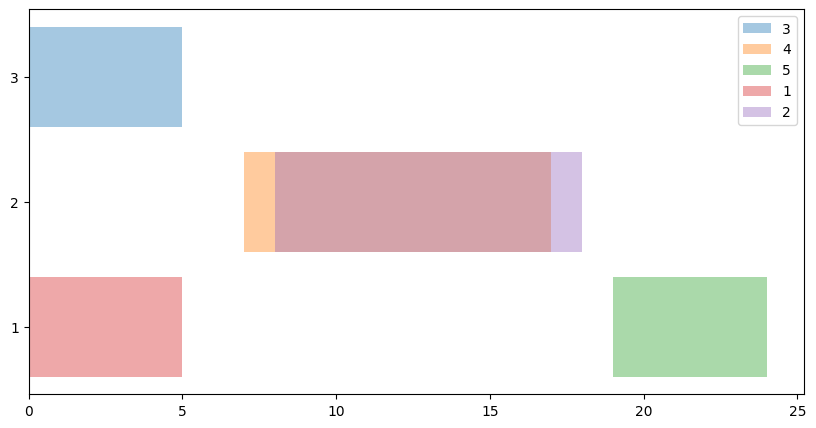

In [15]:
# put the machines in the y-axis, following the gantt chart from the previous cell
# plot the gantt chart with data from df

fig, ax = plt.subplots(figsize=(10, 5))

# unique operations
unique_operations = df["Task"].unique()
color_list = px.colors.qualitative.Dark24[: len(unique_operations)]
color_dict = dict(zip(unique_operations, color_list))

# color all the operations with the same color
for idx, row in df.iterrows():
    # Adding a lower bar - for the overall task duration
    plt.barh(
        y=row["Resource"],
        # y=row["operation"],
        width=row["Delta"],
        left=row["Start"],
        # color=color_dict.get(row["Task"]),
        # color="grey",
        alpha=0.4,
        label=row["operation"],
    )

#
plt.gca().invert_yaxis()

# # only keep unique labels and sort the labels and handles by labels
# handles, labels = plt.gca().get_legend_handles_labels()
# by_label = OrderedDict(zip(labels, handles))
# # sort the labels and handles by labels
# by_label = OrderedDict(sorted(by_label.items(), key=lambda item: item[0]))
# plt.legend(
#     by_label.values(),
#     [tag.replace("OPERATION_", "") for tag in by_label.keys()],
#     title="Operations",
#     # loc="upper right",
#     # bbox_to_anchor=(1.30, 1.05),
#     loc="lower center",
#     ncols=3,
#     bbox_to_anchor=(0.5, -0.4),
# )

machines_id_name_dict = {i: machine for i, machine in machines.items()}
# get y labels from ax.get_yticklabels
y_ticks_old = ax.get_yticklabels()
y_ticks_new = [fjss2.machines.get(y_label.get_text()) for y_label in y_ticks_old]
# assign y_ticks_new as the new y labels
# ax.set_yticklabels(y_ticks_new)

plt.legend()
plt.show()
# plt.savefig("gantt_chart_case0_ws_all_operations.png", dpi=300)

In [16]:
df

,Task,Resource,Start,Finish,operation,Delta
2,2,3,0.0,5.0,3,5.0
3,2,2,7.0,17.0,4,10.0
4,2,1,19.0,24.0,5,5.0
0,1,1,0.0,5.0,1,5.0
1,1,2,8.0,18.0,2,10.0
